# Import library


In [1]:
import torch
import os
import gc
import glob
import numpy as np
import time
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from IPython.display import clear_output
from torchvision import transforms
from collections import namedtuple, deque
from PIL import Image
from typing import Any
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
from models import Discriminator, Generator, weights_init
from dataset import GeneratorDataset, ImageBuffer
from torch.optim import lr_scheduler
import random

# Train


## INIT PARAM


In [2]:
INPUT_SHAPE = 96
SCALE_WIDTH = 96
# Dataset path
base_logdir = os.path.join(os.getcwd(), "logs_gan")
OUTPUT_PATH = os.path.join(os.getcwd(), "output")

USE_BUFFER = True  # Use image buffer to train discriminator
REPLAY_PROB = 0.5  # The probability of using previous fake images to train discriminator
BUFFER_SIZE = 50  # The maximum size of image buffer
BATCH_SIZE = 5
EPOCH = 200
CURRENT_EPOCH = 1  # Epoch start from
SAVE_EVERY_N_EPOCH = 5  # Save checkpoint at every n epoch

# Discriminator loss will be multiplied by this weight
DISCRIMINATOR_LOSS_WEIGHT = 0.5
# The label of fake label will be generated within this range.
SOFT_FAKE_LABEL_RANGE = [0.0, 0.3]
# The label of real label will be generated within this range.
SOFT_REAL_LABEL_RANGE = [0.7, 1.2]
LR = 0.0002
LR_DECAY_EPOCH = 100
LAMBDA = 10  # loss weight for cycle consistency
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
writer = SummaryWriter(base_logdir)

In [3]:
def denormalize(images, std=0.5, mean=0.5):
    # For plot
    images = (images * std) + mean
    return images


def deprocess(input_tensor):
    if len(input_tensor.shape) == 3:
        return np.transpose(denormalize(input_tensor.to(device).cpu()), (1, 2, 0))
    elif len(input_tensor.shape) == 4:
        return np.transpose(denormalize(input_tensor.to(device).cpu()), (0, 2, 3, 1))

## Create Model


In [4]:
G_XtoY = Generator().to(device)
G_YtoX = Generator().to(device)
G_XtoY.apply(weights_init)
G_YtoX.apply(weights_init)

D_X = Discriminator().to(device)
D_Y = Discriminator().to(device)
D_X.apply(weights_init)
D_Y.apply(weights_init)

c:\Users\nguye\anaconda3\envs\python_pytorch\Lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Discriminator(
  (model): Sequential(
    (0): LazyConv2d(0, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): ConvBlock(
      (block): Sequential(
        (0): LazyConv2d(0, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
    (3): ConvBlock(
      (block): Sequential(
        (0): LazyConv2d(0, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
    (4): ConvBlock(
      (block): Sequential(
        (0): LazyConv2d(0, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
    (5): LazyConv2d(0, 1, kernel_size=(4, 4), stride=(1, 1), padding=(

## Prepare Data


In [5]:

preprocess_train_transformations = transforms.Compose([
    transforms.CenterCrop(INPUT_SHAPE),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

preprocess_test_transformations = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

list_dir_data_X = [
    os.path.join(os.path.dirname(os.getcwd()),
                 "dataset", "mtdataset_96", "with"),
    os.path.join(os.path.dirname(os.getcwd()), "dataset", "gan_makeup_data_96", "with")]
data_X = GeneratorDataset(
    list_dir_data_X, transform=preprocess_train_transformations)
train_data_X, test_data_X = random_split(data_X, [0.9, 0.1])

list_dir_data_Y = [
    os.path.join(os.path.dirname(os.getcwd()),
                 "dataset", "mtdataset_96", "without"),
    os.path.join(os.path.dirname(os.getcwd()), "dataset", "gan_makeup_data_96", "without")]
data_Y = GeneratorDataset(
    list_dir_data_Y, transform=preprocess_train_transformations)
train_data_Y, test_data_Y = random_split(data_Y, [0.9, 0.1])

train_dataloader_X = DataLoader(
    train_data_X, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_dataloader_X = DataLoader(
    test_data_X, batch_size=BATCH_SIZE, shuffle=True)
train_dataloader_Y = DataLoader(
    train_data_Y, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_dataloader_Y = DataLoader(
    test_data_Y, batch_size=BATCH_SIZE, shuffle=True)

print(len(train_data_X), len(test_data_X), len(train_data_Y), len(test_data_Y))

3427 380 1987 220


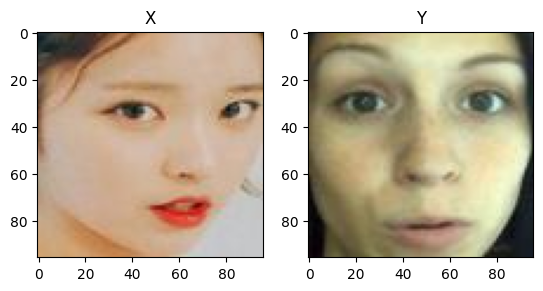

In [6]:
iter_train_image_X = iter(train_dataloader_X)
iter_train_image_Y = iter(train_dataloader_Y)
iter_test_image_X = iter(test_dataloader_X)
iter_test_image_Y = iter(test_dataloader_Y)
sample_X = next(iter_test_image_X)
sample_Y = next(iter_test_image_Y)
fig, axs = plt.subplots(1, 2)
axs[0].set_title('X')
axs[0].imshow(deprocess(sample_X)[0])
axs[1].set_title('Y')
axs[1].imshow(deprocess(sample_Y)[0])

image_buffer = ImageBuffer(buffer_size=BUFFER_SIZE)
training_steps = min(len(train_data_X), len(train_data_Y))

## Optimizer


In [7]:
G_XtoY_optimizer = torch.optim.Adam(
    G_XtoY.parameters(), lr=0.0002, betas=(0.5, 0.999))
G_YtoX_optimizer = torch.optim.Adam(
    G_YtoX.parameters(), lr=0.0002, betas=(0.5, 0.999))
D_X_optimizer = torch.optim.Adam(
    D_X.parameters(), lr=0.0002, betas=(0.5, 0.999))
D_Y_optimizer = torch.optim.Adam(
    D_Y.parameters(), lr=0.0002, betas=(0.5, 0.999))


def lambda_rule(epoch):
    lr = 1.0 - max(0, epoch + 1 - LR_DECAY_EPOCH) / float(LR_DECAY_EPOCH + 1)
    return lr


D_X_optimizer_scheduler = lr_scheduler.LambdaLR(
    D_X_optimizer, lr_lambda=lambda_rule)
D_Y_optimizer_scheduler = lr_scheduler.LambdaLR(
    D_Y_optimizer, lr_lambda=lambda_rule)
G_XtoY_optimizer_scheduler = lr_scheduler.LambdaLR(
    G_XtoY_optimizer, lr_lambda=lambda_rule)
G_YtoX_optimizer_scheduler = lr_scheduler.LambdaLR(
    G_YtoX_optimizer, lr_lambda=lambda_rule)

## Loss Function


In [8]:
def discriminator_loss(real_image_vector, generated_image_vector):
    real_loss = (real_image_vector - torch.FloatTensor(real_image_vector.size()).uniform_(SOFT_REAL_LABEL_RANGE[0],
                                                                                          SOFT_REAL_LABEL_RANGE[1]).to(device)).pow(2).mean()
    fake_loss = (generated_image_vector - torch.FloatTensor(generated_image_vector.size()).uniform_(SOFT_FAKE_LABEL_RANGE[0],
                                                                                                    SOFT_FAKE_LABEL_RANGE[1]).to(device)).pow(2).mean()
    total_loss = real_loss + fake_loss
    return total_loss * 0.5


def generator_loss(generated_image):
    loss = (generated_image - torch.FloatTensor(generated_image.size()).uniform_(SOFT_REAL_LABEL_RANGE[0],
                                                                                 SOFT_REAL_LABEL_RANGE[1]).to(device)).pow(2).mean()
    return loss

# def discriminator_loss(real_image, generated_image):
#     pass


# def generator_loss(generated_image):
#     pass


def cycle_consistency_loss(real_image, cycled_image):
    loss = (real_image - cycled_image).pow(2).mean()
    return loss * LAMBDA


def identity_loss(real_image, generated_image):
    loss = (real_image - generated_image).abs().mean()
    return loss * 0.5 * LAMBDA

In [9]:
torch.manual_seed(42)
real_image_vector = torch.randn((1, 3, 96, 96)).cuda()
fake_image = torch.randn((1, 3, 96, 96)).cuda()
print(cycle_consistency_loss(real_image_vector, fake_image))

tensor(20.0812, device='cuda:0')


## Load Check Point


In [10]:
checkpoint_path = os.path.join(os.getcwd(), "checkpoints")

if not os.path.exists(checkpoint_path):
    os.makedirs(checkpoint_path)


def save_training_checkpoint(epoch):
    state_dict = {
        'G_XtoY': G_XtoY.state_dict(),
        'G_YtoX': G_YtoX.state_dict(),
        'D_X': D_X.state_dict(),
        'D_Y': D_Y.state_dict(),
        'G_XtoY_optimizer': G_XtoY_optimizer.state_dict(),
        'G_YtoX_optimizer': G_YtoX_optimizer.state_dict(),
        'D_X_optimizer': D_X_optimizer.state_dict(),
        'D_Y_optimizer': D_Y_optimizer.state_dict(),
        'D_X_optimizer_scheduler': D_X_optimizer_scheduler.state_dict(),
        'D_Y_optimizer_scheduler': D_Y_optimizer_scheduler.state_dict(),
        'G_XtoY_optimizer_scheduler': G_XtoY_optimizer_scheduler.state_dict(),
        'G_YtoX_optimizer_scheduler': G_YtoX_optimizer_scheduler.state_dict(),
        'epoch': epoch
    }

    save_path = os.path.join(checkpoint_path, 'training-checkpoint')
    torch.save(state_dict, save_path)


def save_models(G_XtoY, G_YtoX, epoch=0):
    state_dict = {
        'G_XtoY': G_XtoY.state_dict(),
        'G_YtoX': G_YtoX.state_dict()
    }
    save_path = os.path.join(checkpoint_path, f'model{epoch}')
    torch.save(state_dict, save_path)


# if a checkpoint exists, restore the latest checkpoint.
if os.path.isfile(os.path.join(checkpoint_path, 'training-checkpoint')):
    checkpoint = torch.load(os.path.join(
        checkpoint_path, 'training-checkpoint'))
    G_XtoY.load_state_dict(checkpoint['G_XtoY'])
    G_YtoX.load_state_dict(checkpoint['G_YtoX'])
    D_X.load_state_dict(checkpoint['D_X'])
    D_Y.load_state_dict(checkpoint['D_Y'])
    G_XtoY_optimizer.load_state_dict(checkpoint['G_XtoY_optimizer'])
    G_YtoX_optimizer.load_state_dict(checkpoint['G_YtoX_optimizer'])
    D_X_optimizer.load_state_dict(checkpoint['D_X_optimizer'])
    D_Y_optimizer.load_state_dict(checkpoint['D_Y_optimizer'])
    D_X_optimizer_scheduler.load_state_dict(
        checkpoint['D_X_optimizer_scheduler'])
    D_Y_optimizer_scheduler.load_state_dict(
        checkpoint['D_Y_optimizer_scheduler'])
    G_XtoY_optimizer_scheduler.load_state_dict(
        checkpoint['G_XtoY_optimizer_scheduler'])
    G_YtoX_optimizer_scheduler.load_state_dict(
        checkpoint['G_YtoX_optimizer_scheduler'])
    CURRENT_EPOCH = checkpoint['epoch']
    print('Latest checkpoint of epoch {} restored!!'.format(CURRENT_EPOCH))

Latest checkpoint of epoch 10 restored!!


## Support function


In [11]:
def generate_images(model, test_input, img_name='img', step=0):
    model.eval()
    with torch.no_grad():
        prediction = model(test_input.to(device)).cpu().detach()
    plt.figure(figsize=(12, 12))

    display_list = [test_input, prediction]
    title = ['Input Image', 'Predicted Image']
    # Using the file writer, log the reshaped image.
    writer.add_image(os.path.join('train', img_name),
                     denormalize(prediction)[0].numpy(), step)
    writer.flush()

    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(deprocess(display_list[i])[0])
        plt.axis('off')
    plt.show()


def generate_test_images(model1, model2, test_input, img_name='img', step=0, show_result=False):
    '''
        Generate images and cycled images, then save them to tensorboard
    '''
    with torch.no_grad():
        prediction1 = model1(test_input.to(device))
        prediction2 = model2(prediction1)

    test_input = test_input.cpu()
    prediction1 = prediction1.cpu()
    prediction2 = prediction2.cpu()
    display_list = [test_input, prediction1, prediction2]
    title = ['Input Image', 'Predicted Image', 'Cycled Image']

    writer.add_image(os.path.join('test', img_name, ' original'),
                     denormalize(test_input)[0].numpy(), step)
    writer.add_image(os.path.join('test', img_name, ' predicted'),
                     denormalize(prediction1)[0].numpy(), step)
    writer.add_image(os.path.join('test', img_name, ' cycled'),
                     denormalize(prediction2)[0].numpy(), step)
    writer.flush()

    if show_result:
        plt.figure(figsize=(12, 12))
        for i in range(3):
            plt.subplot(1, 3, i+1)
            plt.title(title[i])
            # getting the pixel values between [0, 1] to plot it.
            plt.imshow(deprocess(display_list[i])[0])
            plt.axis('off')
        plt.show()


def save_test_images(model1, model2, test_input, folder_name='img', step=0, save=False, show_result=False):
    '''
        Generate images and cycled images, then save them as jpg
    '''
    with torch.no_grad():
        prediction1 = model1(test_input.to(device))
        prediction2 = model2(prediction1)

    test_input = test_input.cpu()
    prediction1 = prediction1.cpu()
    prediction2 = prediction2.cpu()

    display_list = [test_input, prediction1, prediction2]
    title = ['original', 'predicted', 'cycled']
    figure_title = ['Input Image', 'Predicted Image', 'Cycled Image']

    base_folder = os.path.join(OUTPUT_PATH, folder_name)
    if not os.path.exists(base_folder):
        os.makedirs(base_folder)

    if save:
        for img, title in zip(display_list, title):
            save_folder = os.path.join(base_folder, title)
            if not os.path.exists(save_folder):
                os.makedirs(save_folder)
            img = deprocess(img)[0]
            plt.imsave(os.path.join(save_folder, '{}.jpg'.format(step)), img)

    if show_result:
        plt.figure(figsize=(12, 12))
        for i in range(3):
            plt.subplot(1, 3, i+1)
            plt.title(figure_title[i])
            # getting the pixel values between [0, 1] to plot it.
            plt.imshow(deprocess(display_list[i])[0])
            plt.axis('off')
        plt.show()


class TimeCounter():
    def __init__(self):
        self.init_time = time.time()
        self.stored_time = self.init_time

    def count(self, task_name="task"):
        current_time = time.time()
        consumed_time = current_time - self.stored_time
        self.stored_time = current_time
        print('Task {}, consume {} sec'.format(task_name, consumed_time))


def eval(G_XtoY, G_YtoX, D_X, D_Y, test_dataloader_X, test_dataloader_Y, epoch=0):
    G_XtoY.eval()
    G_YtoX.eval()
    D_X.eval()
    D_Y.eval()
    valid_G_XtoY_loss_mean = 0
    valid_G_YtoX_loss_mean = 0
    valid_D_X_loss_mean = 0
    valid_D_Y_loss_mean = 0
    valid_step = min(len(test_dataloader_X), len(test_dataloader_Y))
    with torch.no_grad():
        # Reset dataloader
        iter_train_image_X = iter(train_dataloader_X)
        iter_train_image_Y = iter(train_dataloader_Y)
        for step in range(valid_step):
            real_image_X = next(iter_train_image_X).to(device)
            real_image_Y = next(iter_train_image_Y).to(device)
            # Generate fake images
            fake_image_X = G_YtoX(real_image_Y).detach()
            fake_image_Y = G_XtoY(real_image_X).detach()
            # Calculate logits after discriminators
            real_X_logits = D_X(real_image_X)
            fake_X_logits = D_X(fake_image_X)
            real_Y_logits = D_Y(real_image_Y)
            fake_Y_logits = D_Y(fake_image_Y)
            # Discriminators loss
            D_X_loss = discriminator_loss(real_X_logits, fake_X_logits)
            D_Y_loss = discriminator_loss(real_Y_logits, fake_Y_logits)
            valid_D_X_loss_mean += D_X_loss.item()
            valid_D_Y_loss_mean += D_Y_loss.item()
            # Generators loss
            G_XtoY_loss = generator_loss(fake_Y_logits)
            G_YtoX_loss = generator_loss(fake_X_logits)
            # Cycle consistency loss
            cycled_XtoYtoX = G_YtoX(fake_image_Y)
            cycled_YtoXtoY = G_XtoY(fake_image_X)
            cycled_XtoY_loss = cycle_consistency_loss(
                real_image_X, cycled_XtoYtoX)
            cycled_YtoX_loss = cycle_consistency_loss(
                real_image_Y, cycled_YtoXtoY)
            total_cycle_loss = cycled_XtoY_loss + cycled_YtoX_loss
            # Identity loss
            same_image_Y = G_XtoY(real_image_Y)
            same_image_X = G_YtoX(real_image_X)
            identity_loss_for_YtoX = identity_loss(real_image_X, same_image_X)
            identity_loss_for_XtoY = identity_loss(real_image_Y, same_image_Y)
            # Combine losses
            total_G_XtoY_loss = G_XtoY_loss + identity_loss_for_XtoY
            total_G_YtoX_loss = G_YtoX_loss + identity_loss_for_YtoX
            valid_G_XtoY_loss_mean += total_G_XtoY_loss.item()
            valid_G_YtoX_loss_mean += total_G_YtoX_loss.item()

        writer.add_scalar('Valid/Loss/total_G_XtoY_loss',
                          valid_G_XtoY_loss_mean / valid_step, epoch)
        writer.add_scalar('Valid/Loss/total_G_YtoX_loss',
                          valid_G_YtoX_loss_mean / valid_step, epoch)
        writer.add_scalar('Valid/Loss/D_X_loss',
                          valid_D_X_loss_mean / valid_step, epoch)
        writer.add_scalar('Valid/Loss/D_Y_loss',
                          valid_D_Y_loss_mean / valid_step, epoch)
        writer.flush()


def train_one_epoch(G_XtoY, G_YtoX, D_X, D_Y, train_dataloader_X, train_dataloader_Y, G_XtoY_optimizer, G_YtoX_optimizer, D_X_optimizer, D_Y_optimizer,  D_X_optimizer_scheduler, D_Y_optimizer_scheduler, G_XtoY_optimizer_scheduler, G_YtoX_optimizer_scheduler, image_buffer, epoch):
    start = time.time()
    print('Start of epoch %d' % (epoch,))
    # Reset dataloader
    iter_train_image_X = iter(train_dataloader_X)
    iter_train_image_Y = iter(train_dataloader_Y)
    training_steps = min(len(train_dataloader_X), len(train_dataloader_Y))
    # Turn on train mode
    G_XtoY.train()
    G_YtoX.train()
    D_X.train()
    D_Y.train()
    # Average the losses of an epoch and write them.
    G_XtoY_loss_mean = 0
    G_YtoX_loss_mean = 0
    D_X_loss_mean = 0
    D_Y_loss_mean = 0
    for step in range(training_steps):

        # The probability to use previous images to train discriminators
        replay_previous = True if REPLAY_PROB > random.random() else False

        real_image_X = next(iter_train_image_X).to(device)
        real_image_Y = next(iter_train_image_Y).to(device)

        # Generate fake images for discriminators
        fake_image_X = G_YtoX(real_image_Y).detach()
        fake_image_Y = G_XtoY(real_image_X).detach()

        image_buffer.add(real_image_X, fake_image_X,
                         real_image_Y, fake_image_Y)

        D_X_optimizer.zero_grad()
        D_Y_optimizer.zero_grad()
        if USE_BUFFER and replay_previous:
            # Get previous generated fake images
            buffered_images = image_buffer.sample()
            # Compute the discriminator loss using buffered images
            real_buffer_image_X = buffered_images.real_image_X
            fake_buffer_image_X = buffered_images.fake_image_X
            real_buffer_image_Y = buffered_images.real_image_Y
            fake_buffer_image_Y = buffered_images.fake_image_Y

            D_X_real_buffer = D_X(real_buffer_image_X)
            D_X_fake_buffer = D_X(fake_buffer_image_X)
            D_X_loss = discriminator_loss(D_X_real_buffer, D_X_fake_buffer)

            D_Y_real_buffer = D_Y(real_buffer_image_Y)
            D_Y_fake_buffer = D_Y(fake_buffer_image_Y)
            D_Y_loss = discriminator_loss(D_Y_real_buffer, D_Y_fake_buffer)
        else:
            # Compute the discriminator loss using the latest fake images
            D_X_real = D_X(real_image_X)
            D_X_fake = D_X(fake_image_X)
            D_Y_real = D_Y(real_image_Y)
            D_Y_fake = D_Y(fake_image_Y)
            D_X_loss = discriminator_loss(D_X_real, D_X_fake)
            D_Y_loss = discriminator_loss(D_Y_real, D_Y_fake)

        # ============================
        # Update discriminators
        # ============================
        D_X_loss.backward()
        D_Y_loss.backward()
        D_X_optimizer.step()
        D_Y_optimizer.step()

        # ============================
        # Compute the generator loss
        # ============================
        G_XtoY_optimizer.zero_grad()
        G_YtoX_optimizer.zero_grad()

        fake_image_Y = G_XtoY(real_image_X)
        fake_image_X = G_YtoX(real_image_Y)
        dis_fake_image_Y = D_Y(fake_image_Y)
        dis_fake_image_X = D_X(fake_image_X)

        G_XtoY_loss = generator_loss(dis_fake_image_Y)
        G_YtoX_loss = generator_loss(dis_fake_image_X)
        # ============================
        # Compute the cycle consistency loss
        # ============================
        cycled_XtoYtoX = G_YtoX(fake_image_Y)
        cycled_YtoXtoY = G_XtoY(fake_image_X)
        cycled_XtoY_loss = cycle_consistency_loss(real_image_X, cycled_XtoYtoX)
        cycled_YtoX_loss = cycle_consistency_loss(real_image_Y, cycled_YtoXtoY)
        total_cycle_loss = cycled_XtoY_loss + cycled_YtoX_loss

        # ============================
        # Compute the identity loss
        # ============================
        same_image_Y = G_XtoY(real_image_Y)
        same_image_X = G_YtoX(real_image_X)
        identity_loss_for_YtoX = identity_loss(real_image_X, same_image_X)
        identity_loss_for_XtoY = identity_loss(real_image_Y, same_image_Y)

        # ============================
        # Combine all generator losses
        # ============================
        total_G_XtoY_loss = G_XtoY_loss + identity_loss_for_XtoY
        total_G_YtoX_loss = G_YtoX_loss + identity_loss_for_YtoX
        total_G_losses = total_G_XtoY_loss + total_G_YtoX_loss + total_cycle_loss
        # ============================
        # Update generators
        # ============================
        total_G_losses.backward()
        G_XtoY_optimizer.step()
        G_YtoX_optimizer.step()

        # Add losses
        G_XtoY_loss_mean = G_XtoY_loss_mean + \
            total_G_XtoY_loss.item() + total_cycle_loss.item()
        G_YtoX_loss_mean = G_YtoX_loss_mean + \
            total_G_YtoX_loss.item() + total_cycle_loss.item()
        D_X_loss_mean += D_X_loss.item()
        D_Y_loss_mean += D_Y_loss.item()

        if step % 10 == 0:
            print('.', end='')

    # ============================
    # Write Training scalars at the end of an epoch
    # ============================
    writer.add_scalar('Train/Loss/total_G_XtoY_loss',
                      G_XtoY_loss_mean / training_steps, epoch)
    writer.add_scalar('Train/Loss/total_G_YtoX_loss',
                      G_YtoX_loss_mean / training_steps, epoch)
    writer.add_scalar('Train/Loss/D_X_loss',
                      D_X_loss_mean / training_steps, epoch)
    writer.add_scalar('Train/Loss/D_Y_loss',
                      D_Y_loss_mean / training_steps, epoch)
    writer.flush()

    # ============================
    # Update schedulers
    # ============================
    D_X_optimizer_scheduler.step()
    D_Y_optimizer_scheduler.step()
    G_XtoY_optimizer_scheduler.step()
    G_YtoX_optimizer_scheduler.step()

    if epoch % SAVE_EVERY_N_EPOCH == 0:
        save_models(G_XtoY, G_YtoX, epoch)
        save_training_checkpoint(epoch)
        print('Saving checkpoint for epoch {} at {}'.format(epoch,
                                                            checkpoint_path))

    print('Time taken for epoch {} is {} sec\n'.format(epoch,
                                                       time.time()-start))

In [12]:
# G_XtoY.summary()
# G_YtoX.summary()
# D_X.summary()
# D_Y.summary()
# # Write graph
# writer.add_graph(G_XtoY, sample_X.to(device))
# writer.add_graph(G_YtoX, sample_Y.to(device))
# writer.add_graph(D_X, sample_X.to(device))
# writer.add_graph(D_Y, sample_Y.to(device))
# writer.flush()

## Train Loop


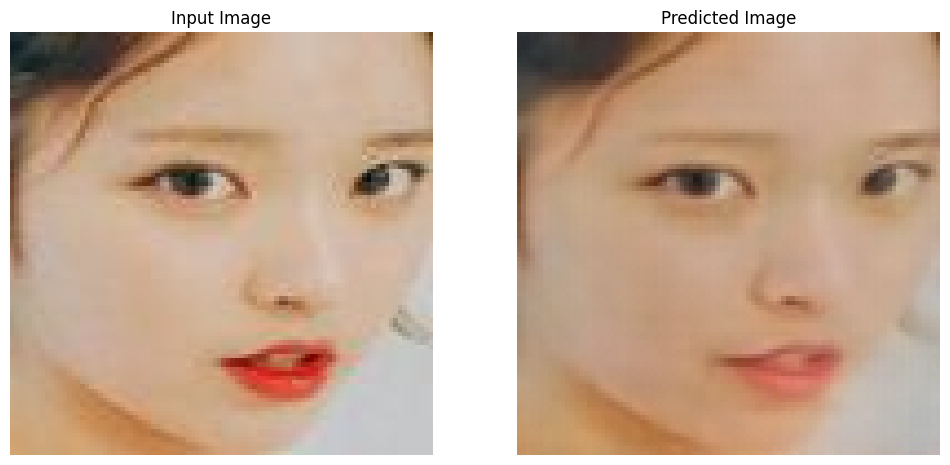

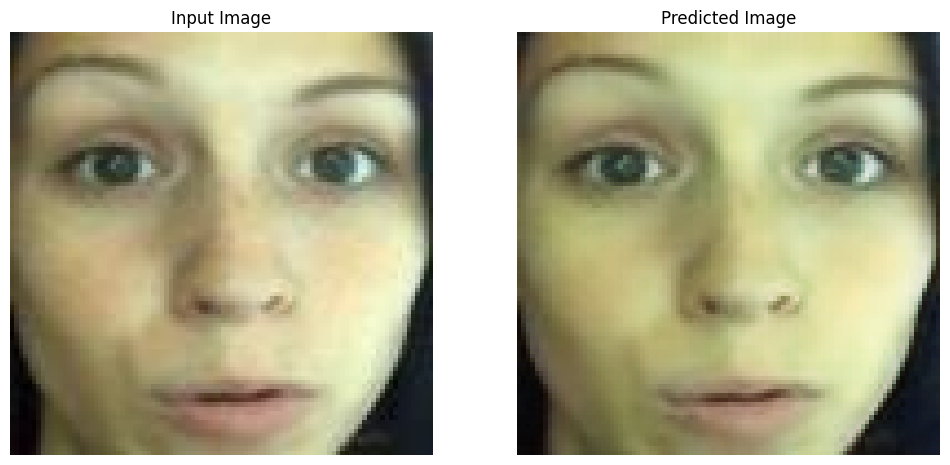

Start of epoch 99
.......................................

In [13]:
current_learning_rate = LR

trace = True
for epoch in range(CURRENT_EPOCH, EPOCH + 1):
    # ============================
    # Train one epoch
    # ============================
    train_one_epoch(G_XtoY, G_YtoX, D_X, D_Y, train_dataloader_X, train_dataloader_Y, G_XtoY_optimizer, G_YtoX_optimizer, D_X_optimizer,
                    D_Y_optimizer, D_X_optimizer_scheduler, D_Y_optimizer_scheduler, G_XtoY_optimizer_scheduler, G_YtoX_optimizer_scheduler, image_buffer, epoch)
    # ============================
    # Write Evaluate scalars at the end of an epoch
    # ============================
    eval(G_XtoY, G_YtoX, D_X, D_Y, test_dataloader_X, test_dataloader_Y, epoch)

    clear_output(wait=True)
    # Show some image
    generate_images(G_XtoY, sample_X, img_name='sample_X', step=epoch)
    generate_images(G_YtoX, sample_Y, img_name='sample_Y', step=epoch)

    gc.collect()